In [1]:
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import boto3
import pickle

In [23]:
df = pd.read_csv("final_wine_dataset.csv")
df.head()

,country,description,points,price,province,title,variety,winery,years
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [24]:
df[df.index.values==10]

,country,description,points,price,province,title,variety,winery,years
10,US,"Red fruit aromas pervade on the nose, with cig...",87,32.0,Virginia,Quiévremont 2012 Meritage (Virginia),Meritage,Quiévremont,2012


In [25]:
test=[4,10,3,40,]
test.sort()
test

[3, 4, 10, 40]

In [8]:
df.index.values[0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [26]:
reviews_list = list(df['description'])
reviews_list = [str(r) for r in reviews_list]
full_corpus = ' '.join(reviews_list)
sentences_tokenized = sent_tokenize(full_corpus)

print(sentences_tokenized[:10])

['This is ripe and fruity, a wine that is smooth while still structured.', 'Firm tannins are filled out with juicy red berry fruits and freshened with acidity.', "It's  already drinkable, although it will certainly be better from 2016.", 'Tart and snappy, the flavors of lime flesh and rind dominate.', 'Some green pineapple pokes through, with crisp acidity underscoring the flavors.', 'The wine was all stainless-steel fermented.', 'Pineapple rind, lemon pith and orange blossom start off the aromas.', 'The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.', 'Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics.', "Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew."]


In [27]:
#Ici nous faisons de preprocessing des mots (tokenizer, suppression ponctuation et stopwords)

stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def cleaning(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

# sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = cleaning(s)
    normalized_sentences.append(normalized_text)

In [29]:
#Certains termes ne sont pas forcément composé d'un mot mais de deux voire plus par exemple :'high tannin'.
#On peut utiliser gensim pour extraire les bi- et tri-grams les plus pertinents depuis notre corpus

phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

In [30]:
# Extraire les mots les plus communs et les classer par fréquence d'apparition

word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')

In [31]:
descriptor_mapping = pd.read_csv('descriptor_mapping.csv').set_index('raw descriptor')
descriptor_mapping.head(10)

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
acacia,acacia,flowery,flower
acacia_flower,acacia,flowery,flower
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid
airi,airy,light_bodied,body
allspic,allspice,baking_spices,spice
almond,almond,nutty,nutty
almond_past,almond,nutty,nutty


In [32]:
wine_mapping = descriptor_mapping['level_3'].unique().tolist()
wine_mapping.sort()

In [33]:
#Ensuite, tous les termes du corpus qui apparaissent dans la vue d'ensemble ci-dessus sont mappés sur la couche « level_3 » (la plus spécifique) du tableau.

def return_mapped_descriptor(word):
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return word

normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        normalized_sentence.append(str(normalized_word))
    normalized_sentences.append(normalized_sentence)

In [34]:
from gensim.models import word2vec

wine_word2vec_model = word2vec.Word2Vec(normalized_sentences, min_count=5, vector_size=300)
print(wine_word2vec_model)


# word2vec.Word2Vec(sentance, size=300, iter=100)

wine_word2vec_model.save('wine_word2vec_model.bin')

Word2Vec(vocab=14686, vector_size=300, alpha=0.025)


In [12]:
# wine_word2vec_model.save('wine_word2vec_model.model')

NameError: name 'wine_word2vec_model' is not defined

In [14]:
model = Word2Vec.load("wine_word2vec_model.model")

In [7]:
#Essai : quels descripteurs de vin sont les plus similaires au mot « peach » ?

my_pickle.wv.most_similar(positive='peach', topn=5)

[('stone_fruit', 0.8693991899490356),
 ('mango', 0.7795745730400085),
 ('honeydew', 0.7794767022132874),
 ('nectarine', 0.7681233286857605),
 ('tangerine', 0.7515990734100342)]

In [36]:
wine_reviews = list(df['description'])

def return_descriptor_from_mapping(word):
    if word in list(descriptor_mapping.index):
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in wine_reviews:
    normalized_review = cleaning(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

In [47]:
import json
with open('dict_of_tfidf_weightings.json', 'w') as fp:
    json.dump(dict_of_tfidf_weightings , fp)

In [48]:
import json

with open("dict_of_tfidf_weightings.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

In [37]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in descriptorized_reviews:
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

df['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
df['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
df['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

df.reset_index(inplace=True)
df.head()

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,index,country,description,points,price,province,title,variety,winery,years,normalized_descriptors,review_vector,descriptor_count
0,0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[ripe, fruit, smooth, firm, juicy, berry, frui...","[[0.63668054, -0.7453226, -0.027602702, -0.519...",8
1,1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[tart, snappy, lime, green, pineapple, crisp, ...","[[1.1218191, 2.8246362, -3.322047, -0.6327367,...",7
2,2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,"[pineapple, rind, lemon_pith, orange_blossom, ...","[[1.1588999, 4.2645965, -2.1869183, 1.9282103,...",6
3,3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,"[rough, tannin, rustic, earth, herb, hearty]","[[0.6271805, -0.10035806, 0.8204902, -0.867445...",6
4,4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,"[blackberry, raspberry, full_bodied, tomato, s...","[[-0.24821872, 0.5162917, 0.41469443, 0.210540...",11


In [38]:
def count_vect (val):
    if len(val)>0:
        x=1
    elif len(val)==0:
        x=0
    return x

df['check_vect']=df['review_vector'].apply(count_vect)

In [39]:
df2=df[df['check_vect']==1]

In [40]:
df2.head()

,index,country,description,points,price,province,title,variety,winery,years,normalized_descriptors,review_vector,descriptor_count,check_vect
0,0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[ripe, fruit, smooth, firm, juicy, berry, frui...","[[0.63668054, -0.7453226, -0.027602702, -0.519...",8,1
1,1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[tart, snappy, lime, green, pineapple, crisp, ...","[[1.1218191, 2.8246362, -3.322047, -0.6327367,...",7,1
2,2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,"[pineapple, rind, lemon_pith, orange_blossom, ...","[[1.1588999, 4.2645965, -2.1869183, 1.9282103,...",6,1
3,3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,"[rough, tannin, rustic, earth, herb, hearty]","[[0.6271805, -0.10035806, 0.8204902, -0.867445...",6,1
4,4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,"[blackberry, raspberry, full_bodied, tomato, s...","[[-0.24821872, 0.5162917, 0.41469443, 0.210540...",11,1


In [22]:
# df2['url_pic']="https://raw.githubusercontent.com/yacine-yame/datasets/main/winebottle.jpg"
# df2.head()

<ipython-input-22-af500bfd54bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['url_pic']="https://raw.githubusercontent.com/yacine-yame/datasets/main/winebottle.jpg"


,index,country,description,points,price,province,title,variety,winery,years,normalized_descriptors,review_vector,descriptor_count,check_vect,url_pic
0,0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[ripe, fruit, smooth, firm, juicy, berry, frui...","[[0.64882517, -0.5569139, -0.2560206, -0.48036...",8,1,https://raw.githubusercontent.com/yacine-yame/...
1,1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[tart, snappy, lime, green, pineapple, crisp, ...","[[-0.16406454, 3.1743882, -3.8573806, -0.00702...",7,1,https://raw.githubusercontent.com/yacine-yame/...
2,2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,"[pineapple, rind, lemon_pith, orange_blossom, ...","[[1.115753, 3.882146, -2.3786142, 1.9385781, -...",6,1,https://raw.githubusercontent.com/yacine-yame/...
3,3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,"[rough, tannin, rustic, earth, herb, hearty]","[[0.9747446, -0.32859448, 1.7476219, 0.3832223...",6,1,https://raw.githubusercontent.com/yacine-yame/...
4,4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,"[blackberry, raspberry, full_bodied, tomato, s...","[[0.2708758, 0.556181, 0.0043508736, 0.7369508...",11,1,https://raw.githubusercontent.com/yacine-yame/...


In [23]:
# df2.to_csv(r'dfrecofilter.csv', index=False)

In [41]:
dfxxxxx=df2.head(1000)

In [43]:
# Save to pickle
dfxxxxx.to_pickle('pickle-file_2711.pkl')
# # Save with compression
# df.to_pickle('pickle-file2.pkl.gz', compression='gzip')

In [38]:
dftestt=pd.read_pickle('pickle-file.pkl')

In [24]:
#version one
# input_vectors = list(df2['review_vector'])
# input_vectors_listed = [a.tolist() for a in input_vectors]
# input_vectors_listed = [a[0] for a in input_vectors_listed]

In [25]:
name_test = "Quinta dos Avidagos 2011 Avidagos Red (Douro)"

df_feat = df2[df2['country']=="US"]
df_query = df2[df2['title']==name_test]
df_final=pd.concat([df_feat, df_query], ignore_index=True)

input_vectors = list(df_final['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]
input_vectors_listed = [a[0] for a in input_vectors_listed]

In [26]:
len(input_vectors_listed)

49344

In [27]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

In [28]:
name_test = "Quinta dos Avidagos 2011 Avidagos Red (Douro)"

wine_test_vector = df_final.loc[df_final['title'] == name_test]['review_vector'].tolist()[0]
# wine_test_vector = test
distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=9)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine =df_final.loc[df_final['title'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
print('_________')

n = 1
for d, i in zip(distance_list, indice_list):
    wine_name = df_final['title'][i]
    wine_descriptors = df_final['normalized_descriptors'][i]
    wine_points = df_final['points'][i]
    wine_variety = df_final['variety'][i]
    wine_country = df_final['country'][i]
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('This wine has the following rating:', wine_points)
    print('This wine has the following variety:', wine_variety)
    print('This wine has the following country:', wine_country)
    print('')
    n+=1

Wine to match: Quinta dos Avidagos 2011 Avidagos Red (Douro)
The original wine has the following descriptors: ['ripe', 'fruit', 'smooth', 'firm', 'juicy', 'berry', 'fruit', 'fresh']
_________
Suggestion 1 : Substance 2006 Me Merlot (Columbia Valley (WA)) with a cosine distance of 0.069
This wine has the following descriptors: ['ripe', 'round', 'juicy', 'blue', 'fruit', 'clean', 'smooth', 'firm']
This wine has the following rating: 88
This wine has the following variety: Merlot
This wine has the following country: US

Suggestion 2 : Boeger 2014 Pinot Grande Pinot Noir (El Dorado) with a cosine distance of 0.073
This wine has the following descriptors: ['spice', 'warm', 'full_bodied', 'firm', 'berry', 'cherry', 'fresh', 'vibrant', 'baking_spices', 'mellow', 'fruit', 'firm']
This wine has the following rating: 92
This wine has the following variety: Pinot Noir
This wine has the following country: US

Suggestion 3 : Keuka Spring 2010 Semi Sweet Riesling (Finger Lakes) with a cosine distanc

In [29]:
# name_test = "Quinta dos Avidagos 2011 Avidagos Red (Douro)"

# wine_test_vector = df2.loc[df2['title'] == name_test]['review_vector'].tolist()[0]
# # wine_test_vector = test
# distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=9)
# distance_list = distance[0].tolist()[1:]
# indice_list = indice[0].tolist()[1:]

# main_wine =df2.loc[df2['title'] == name_test]

# print('Wine to match:', name_test)
# print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
# print('_________')

# n = 1
# for d, i in zip(distance_list, indice_list):
#     wine_name = df2['title'][i]
#     wine_descriptors = df2['normalized_descriptors'][i]
#     wine_points = df2['points'][i]
#     wine_variety = df2['variety'][i]
#     wine_country = df2['country'][i]
#     print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
#     print('This wine has the following descriptors:', wine_descriptors)
#     print('This wine has the following rating:', wine_points)
#     print('This wine has the following variety:', wine_variety)
#     print('This wine has the following country:', wine_country)
#     print('')
#     n+=1

In [30]:
def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
    weighted_review_terms = []
    for term in list_of_descriptors:
        if term not in dict_of_tfidf_weightings:
            if term not in descriptor_mapping.index:
                print('choose a different descriptor from', term)
                continue
            else:
                term = descriptor_mapping['normalized'][term]
        tfidf_weighting = dict_of_tfidf_weightings[term]
        word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
        weighted_word_vector = tfidf_weighting * word_vector
        weighted_review_terms.append(weighted_word_vector)
    review_vector = sum(weighted_review_terms)
    
    distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
    distance_list = distance[0].tolist()[1:]
    indice_list = indice[0].tolist()[1:]

    n = 1
    for d, i in zip(distance_list, indice_list):
        wine_name = df_final['title'][i]
        wine_descriptors = df_final['normalized_descriptors'][i]
        print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
        print('This wine has the following descriptors:', wine_descriptors)
        print('')
        n+=1
    
descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

Suggestion 1 : Upper Five 2015 Sauvignon Blanc (Rogue Valley) with a cosine distance of 0.079
This wine has the following descriptors: ['snappy', 'petrol', 'pungent', 'lime', 'citrus', 'fruit', 'light_bodied']

Suggestion 2 : Refugio Ranch 2011 Tiradora Sauvignon Blanc (Santa Ynez Valley) with a cosine distance of 0.084
This wine has the following descriptors: ['sharp', 'pungent', 'grass', 'citrus', 'light_bodied', 'brisk', 'apple', 'kiwi', 'fresh']

Suggestion 3 : Keuka Spring 2014 Dry Riesling (Finger Lakes) with a cosine distance of 0.089
This wine has the following descriptors: ['lime_peel', 'grass', 'herb', 'fresh', 'dry', 'tart', 'grapefruit', 'pineapple', 'citrus']

Suggestion 4 : J. Scott Cellars 2011 Sauvignon Blanc (Rogue Valley) with a cosine distance of 0.092
This wine has the following descriptors: ['crisp', 'refreshing', 'fresh', 'herb', 'sweet', 'grass', 'lime', 'grapefruit', 'citrus', 'herb']

Suggestion 5 : Sbragia 2006 Home Ranch Sauvignon Blanc (Dry Creek Valley) wit

In [31]:
# def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
#     weighted_review_terms = []
#     for term in list_of_descriptors:
#         if term not in dict_of_tfidf_weightings:
#             if term not in descriptor_mapping.index:
#                 print('choose a different descriptor from', term)
#                 continue
#             else:
#                 term = descriptor_mapping['normalized'][term]
#         tfidf_weighting = dict_of_tfidf_weightings[term]
#         word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
#         weighted_word_vector = tfidf_weighting * word_vector
#         weighted_review_terms.append(weighted_word_vector)
#     review_vector = sum(weighted_review_terms)
    
#     distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
#     distance_list = distance[0].tolist()[1:]
#     indice_list = indice[0].tolist()[1:]

#     n = 1
#     for d, i in zip(distance_list, indice_list):
#         wine_name = df2['title'][i]
#         wine_descriptors = df2['normalized_descriptors'][i]
#         print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
#         print('This wine has the following descriptors:', wine_descriptors)
#         print('')
#         n+=1
    
# descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
# descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

In [32]:
# On supprime les lignes qui ont moins de 5 élements décrivant les vins
df3 = df2.loc[df2['descriptor_count'] > 5]
df3.reset_index(inplace=True)

variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache', 'CarmenÃ¨re': 'Carmenere',
                    'GrÃ¼ner Veltliner': 'Gruner Veltliner', 'TorrontÃ©s': 'Torrontes', 
                   'RhÃ´ne-style Red Blend': 'Rhone-style Red Blend', 'AlbariÃ±o': 'Albarino',
                  'GewÃ¼rztraminer': 'Gewurztraminer', 'RhÃ´ne-style White Blend': 'Rhone-style White Blend'}

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_reviews_clean = df3.copy()
wine_reviews_clean['variety'] = wine_reviews_clean['variety'].apply(consolidate_varieties)

def subset_wine_vectors(list_of_varieties):
    wine_variety_vectors = []
    for v in list_of_varieties:
        one_var_only = wine_reviews_clean.loc[wine_reviews_clean['variety'] == v]#Selection de tous les vins ayant la même variety ds df 'one_var_only'
        review_arrays = one_var_only['review_vector'].apply(lambda x: x[0])#Selection d'une seule variable (première) pour chaque vins
        average_variety_vec = np.average(review_arrays)#on calcule la moyenne sur tous les vins
        wine_variety_vector = [v, average_variety_vec]#On associe la variety à sa valeur moyenne
        wine_variety_vectors.append(wine_variety_vector)#On ajoute couple variety/valeur moyenne dans une liste
    return wine_variety_vectors

def pca_wine_variety(list_of_varieties):
    wine_var_vectors = subset_wine_vectors(list_of_varieties)#on prend le résultat de la fonction précédente
    pca = PCA(n_components=2)#On effectue une PCA pour résumer l'information sur chaque couple variety/val
    pca.fit([w[1] for w in wine_var_vectors])  
    pca_dataset = pca.fit_transform([w[1] for w in wine_var_vectors])
    pca_dataframe = pd.DataFrame(pca_dataset, columns=['pca_1', 'pca_2'])
    pca_dataframe.index = [w[0] for w in wine_var_vectors]
    # print(pca_dataframe)
    return pca_dataframe


In [33]:
most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
                        'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albarino', 'Pinot Blanc', 'Verdejo',
                        'Torrontes', 'Vermentino', 'Melon', 'Gewurztraminer', 'Rhone-style White Blend']

most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
                         'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
                         'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay','Tempranillo Blend, Tempranillo', 'Petite Sirah',
                        'Barbera', "Nero d'Avola, Italian Red"]

varietydf=df2['variety'].unique().tolist()

selected_white_wine=[]
selected_red_wine=[]

for i in varietydf:
    if i in most_common_whites:
        selected_white_wine.append(i)
    else:
        pass
    
for i in varietydf:
    if i in most_common_reds:
        selected_red_wine.append(i)
    else:
        pass

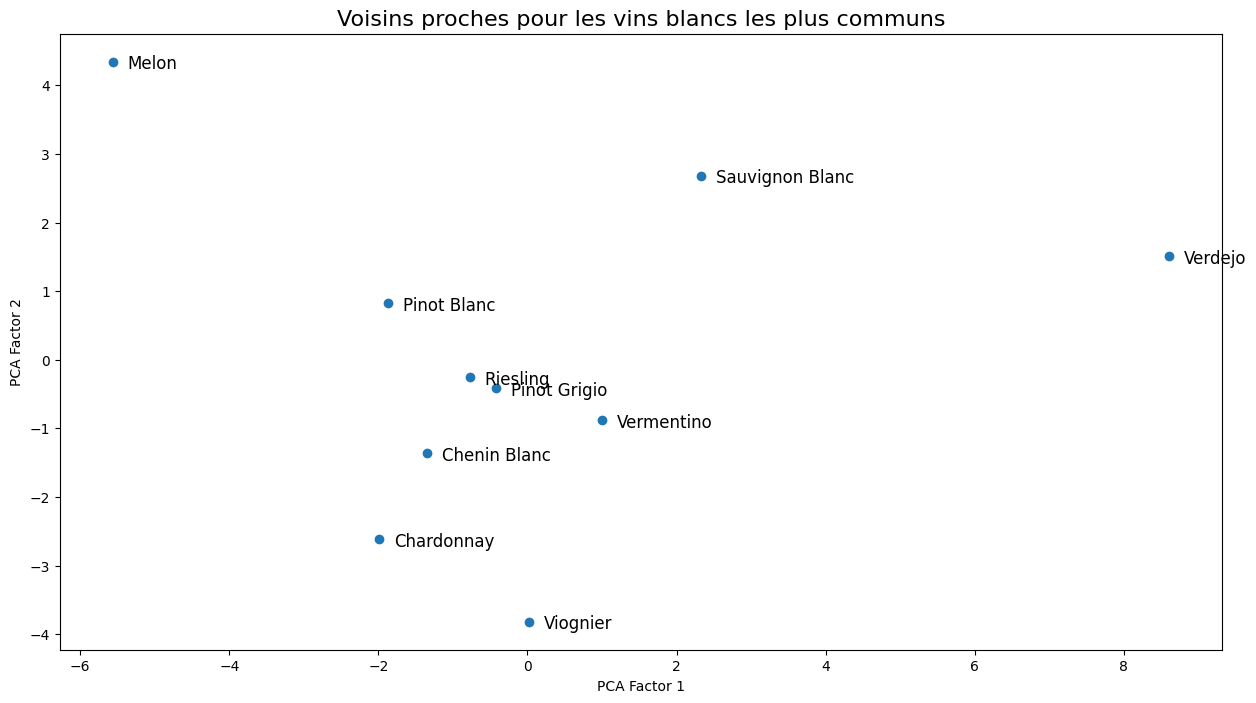

In [34]:
# most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio','Chenin Blanc','Pinot Blanc', 'Verdejo',
#                      'Gewurztraminer']

# most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
#                         'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albarino', 'Pinot Blanc', 'Verdejo',
#                         'Torrontes', 'Vermentino', 'Melon', 'Gewurztraminer', 'Rhone-style White Blend']

pca_w_dataframe = pca_wine_variety(selected_white_wine)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Voisins proches pour les vins blancs les plus communs', fontsize=16)
plt.show()

In [35]:
pca_w_dataframe

,pca_1,pca_2
Riesling,-0.773256,-0.258134
Chenin Blanc,-1.343580,-1.361517
Sauvignon Blanc,2.334233,2.685417
Chardonnay,-1.986100,-2.617977
Viognier,0.014601,-3.819181
Vermentino,0.996674,-0.883827
Pinot Blanc,-1.871103,0.822074
Verdejo,8.611213,1.507328
Pinot Grigio,-0.418074,-0.418985
Melon,-5.564608,4.344802


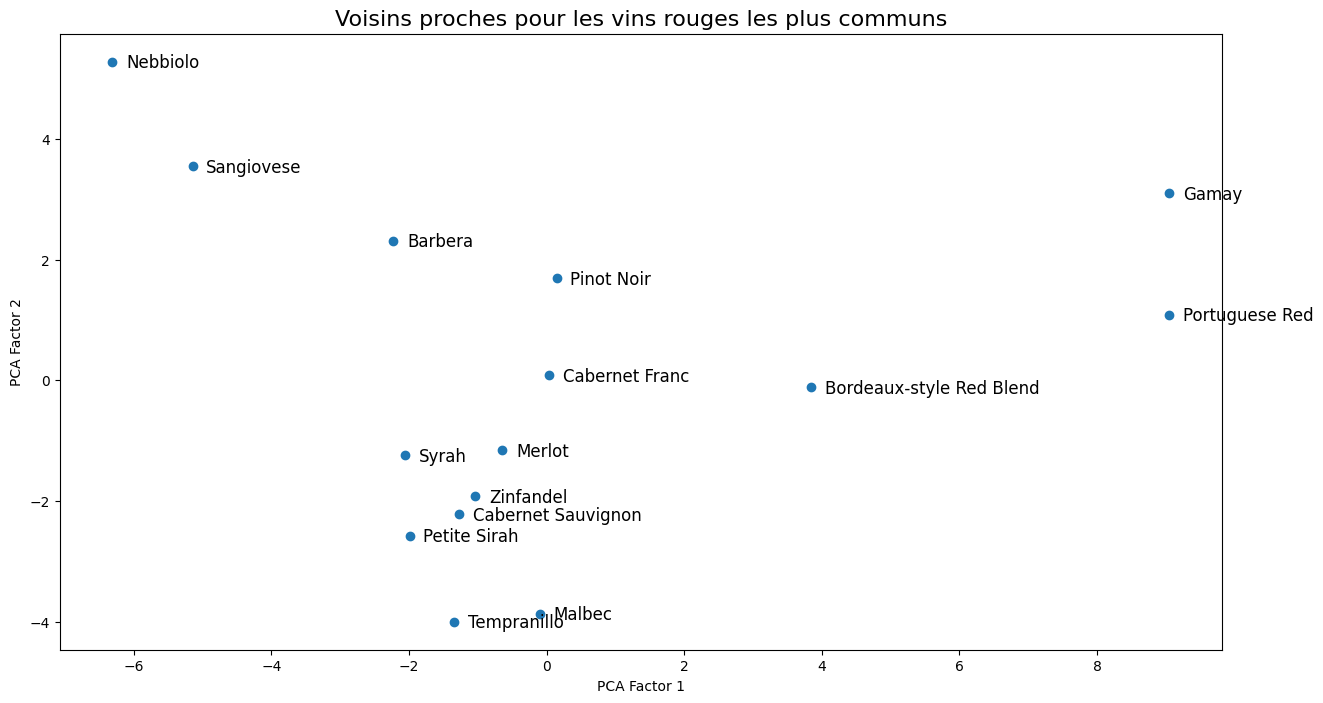

In [36]:
pca_w_dataframe = pca_wine_variety(selected_red_wine)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Voisins proches pour les vins rouges les plus communs', fontsize=16)
plt.show()